In [1]:
from pynq import DefaultHierarchy
from pynq import allocate
from math import log
import numpy as np
class FFT_Block_Driver(DefaultHierarchy):
    def init(self, description):
        super().init(description)
        self.configuration = 0
        self.fft_size = 0

    def _convert_to_data(self,fft_direction,size):
        fft_direction.zfill(8)
        byte2 = '0' * 8
        x = int(log(size,2))
        fft_size = bin(x)[2:]
        fft_size.zfill(8)
        tdata = fft_direction + byte2 + fft_size
        return int(tdata,2)

    def configure(self,fft_direction,fft_size):
        self.configuration = self._convert_to_data(fft_direction,fft_size)
        temp = allocate(1,np.uint32)
        temp[0] = self.configuration
        self.config_dma.sendchannel.transfer(temp)
        self.config_dma.sendchannel.wait()
        del temp

    def stream_fft(self, input_buffer):
        out_buffer = allocate(SAMPLES, np.csingle)
        self.data_dma.sendchannel.transfer(input_buffer)
        self.data_dma.sendchannel.transfer(out_buffer)
        self.data_dma.sendchannel.wait()
        self.data_dma.sendchannel.wait()
        return out_buffer

    @staticmethod
    def checkhierarchy(description):
        if 'data_dma' in description['ip'] \
            and 'config_dma' in description['ip']:
                return True
        return False 

In [2]:
from pynq import Overlay
ol = Overlay('reconf_fft2.bit')

In [3]:
ol?

In [4]:
fft = ol.fft_block

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [6]:
SAMPLES = 1024

In [7]:
time_interval = 1
def create_data(SAMPLES, time_interval):
    A1 = random.uniform(100,1000)
    A2 = random.uniform(100,1000)
    A3 = random.uniform(100,1000)
    f1 = random.uniform(100,150)
    f2 = random.uniform(200,300)
    f3 = random.uniform(500,600)
    w1 = 2 * np.pi * f1
    w2 = 2 * np.pi * f2
    w3 = 2 * np.pi * f3
    t = np.linspace(0, time_interval, SAMPLES)
    data = A1 * np.sin(w1 * t, dtype = np.csingle) + A2 * np.sin(w2 * t, dtype = np.csingle) + A3 * np.sin(w3 * t, dtype = np.csingle)
    return data, t 

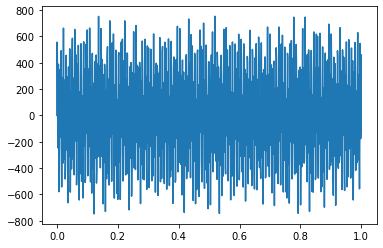

In [8]:
data, t = create_data(SAMPLES, time_interval)
plt.plot(t, np.real(data))

In [9]:
sw_fft = np.fft.fft(data)

In [10]:
input_buffer = allocate(SAMPLES, np.csingle)

In [11]:
np.copyto(input_buffer, data)

In [12]:
fft.configure('1', SAMPLES)

In [13]:
output = fft.stream_fft(input_buffer)

# Plots

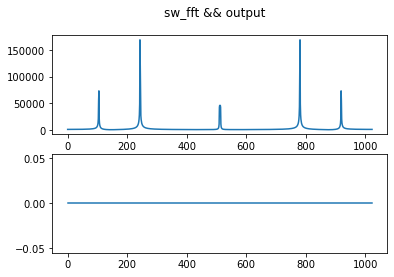

In [25]:
fig, axs = plt.subplots(2)
fig.suptitle('sw_fft && output')
axs[0].plot(np.abs(sw_fft))
axs[1].plot(np.abs(output))


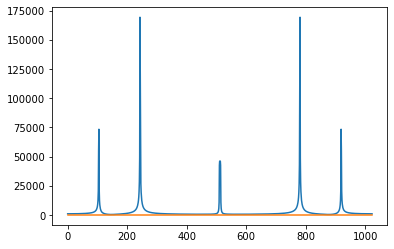

In [16]:
plt.plot(np.abs(sw_fft))
plt.plot(np.abs(output))

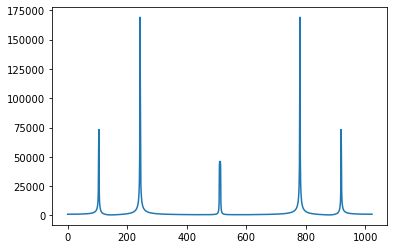

In [17]:
plt.plot(np.abs(np.abs(sw_fft) - np.abs(output)))